Literature Data Loaded for Validation.


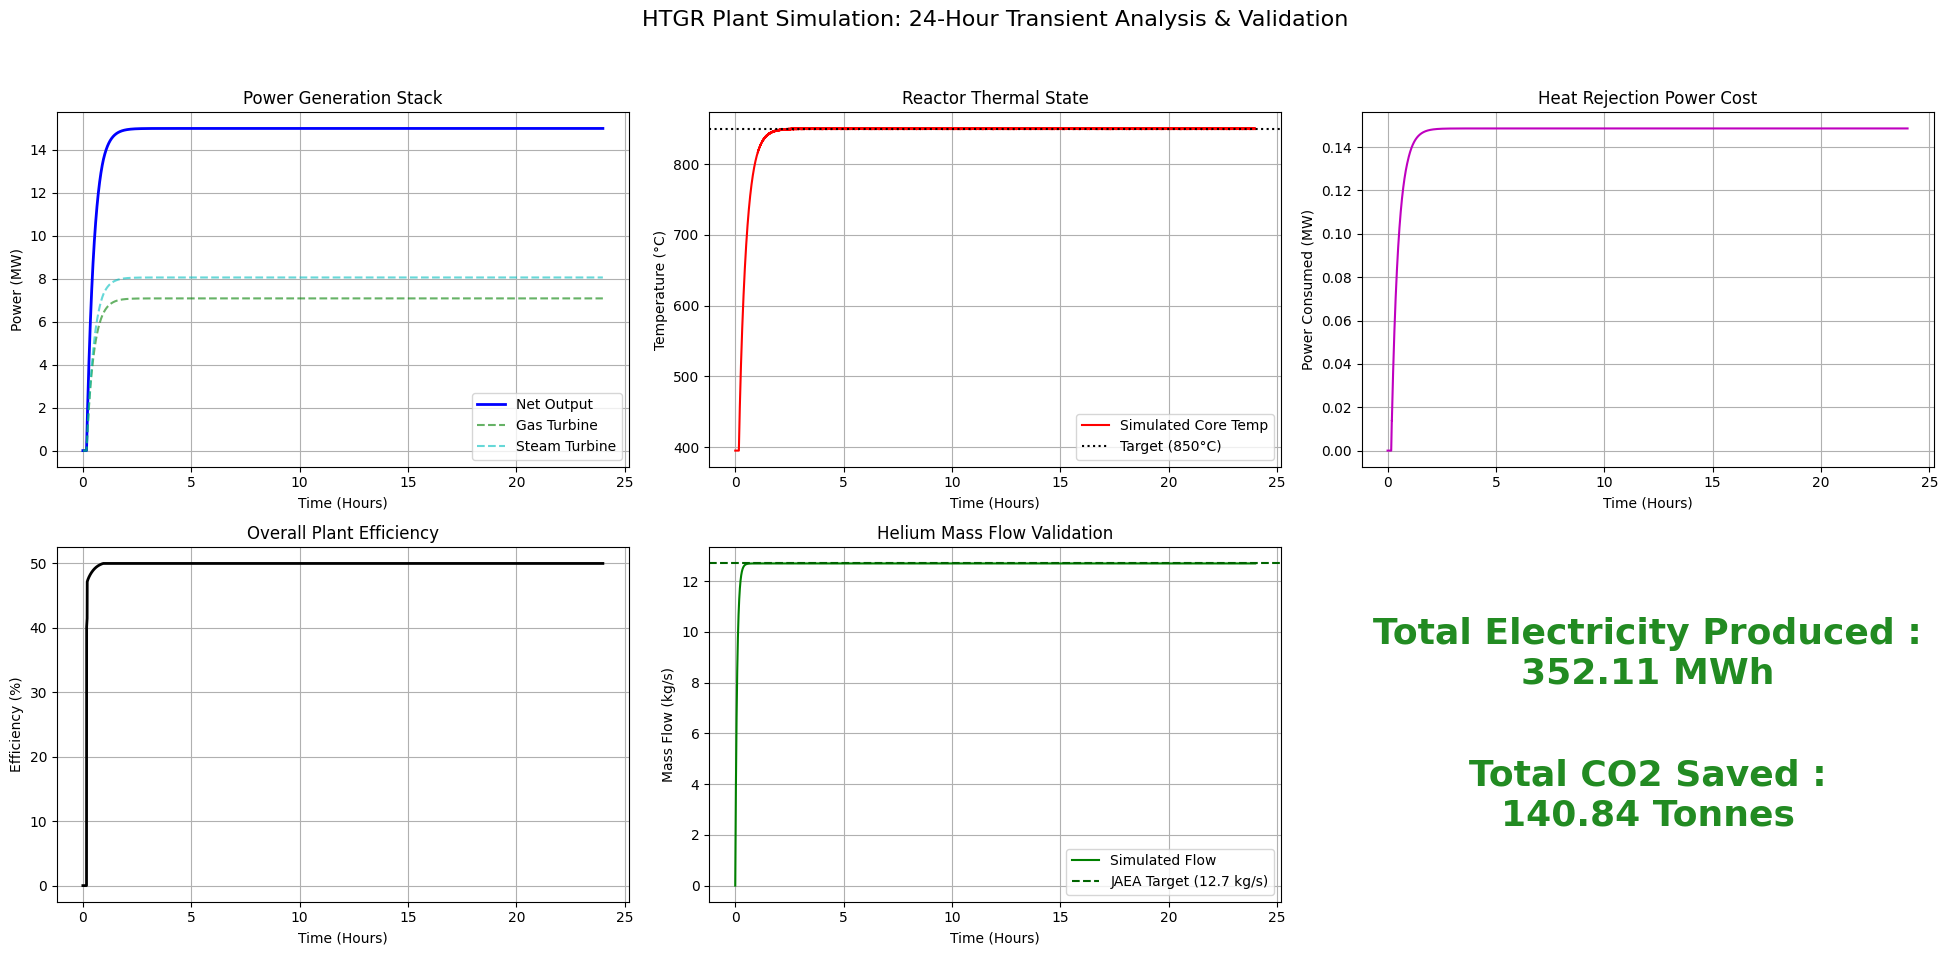

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

csv_path = os.path.join('..', 'results', 'simulation_log.csv')
lit_path = os.path.join('..', 'data', 'literature_data.csv')

if not os.path.exists(csv_path):
    print("ERROR: Run src/simulation.py first to generate data!")
else:
    df = pd.read_csv(csv_path)

    df['Time_Hrs'] = df['Time'] / 3600.0
    co2_factor = 0.4  # Tonnes CO2 per MWh
    df['Energy_MWh'] = df['Net_Power_MW'] * ((86400 / len(df)) / 3600.0) 
    total_electricity_produced = df['Energy_MWh'].sum()
    total_co2_saved = total_electricity_produced * co2_factor

    lit_df = None
    if os.path.exists(lit_path):
        lit_df = pd.read_csv(lit_path)
        print("Literature Data Loaded for Validation.")

    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    plt.subplots_adjust(hspace=0.4)
    fig.suptitle('HTGR Plant Simulation: 24-Hour Transient Analysis & Validation', fontsize=16)

    # --- PLOT A: POWER GENERATION ---
    axs[0, 0].plot(df['Time_Hrs'], df['Net_Power_MW'], 'b-', linewidth=2, label='Net Output')
    axs[0, 0].plot(df['Time_Hrs'], df['Brayton_Power_MW'], 'g--', alpha=0.6, label='Gas Turbine')
    axs[0, 0].plot(df['Time_Hrs'], df['Rankine_Power_MW'], 'c--', alpha=0.6, label='Steam Turbine')
    axs[0, 0].set_title('Power Generation Stack')
    axs[0, 0].set_ylabel('Power (MW)')
    axs[0, 0].set_xlabel('Time (Hours)')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # --- PLOT B: TEMPERATURES (WITH VALIDATION) ---
    axs[0, 1].plot(df['Time_Hrs'], df['Reactor_Temp_C'], 'r-', label='Simulated Core Temp')
    axs[0, 1].axhline(y=850, color='k', linestyle=':', label='Target (850°C)')
        
    axs[0, 1].set_title('Reactor Thermal State')
    axs[0, 1].set_ylabel('Temperature (°C)')
    axs[0, 1].set_xlabel('Time (Hours)')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # --- PLOT C: PARASITIC LOAD & CO2 ---
    axs[0, 2].plot(df['Time_Hrs'], df['Parasitic_Load_MW'], 'm-')
    axs[0, 2].set_title('Heat Rejection Power Cost')
    axs[0, 2].set_ylabel('Power Consumed (MW)')
    axs[0, 2].set_xlabel('Time (Hours)')
    axs[0, 2].grid(True)


    # --- PLOT D: EFFICIENCY ---
    axs[1, 0].plot(df['Time_Hrs'], df['System_Efficiency'] * 100, 'k-', linewidth=2)
    axs[1, 0].set_title('Overall Plant Efficiency')
    axs[1, 0].set_ylabel('Efficiency (%)')
    axs[1, 0].set_xlabel('Time (Hours)')
    axs[1, 0].grid(True)
    
    # --- PLOT E: MASS FLOW ---
    axs[1, 1].plot(df['Time_Hrs'], df['Mass_Flow_kg_s'], color='green', label='Simulated Flow')

    if lit_df is not None:
        target_row = lit_df[lit_df['test_id'] == 'HTTR_Rated_30MW']
        if not target_row.empty:
            target_val = target_row['mass_flow_kg_s'].values[0]
            axs[1, 1].axhline(y=target_val, color='darkgreen', linestyle='--', 
                            label=f'JAEA Target ({target_val} kg/s)')

    axs[1, 1].set_title('Helium Mass Flow Validation')
    axs[1, 1].set_ylabel('Mass Flow (kg/s)')
    axs[1, 1].set_xlabel('Time (Hours)')
    axs[1, 1].legend()
    axs[1, 1].grid(True)
    
    axs[1, 2].axis('off')
    axs[1, 2].text(0.5, 0.3, f'Total CO2 Saved :\n{total_co2_saved:.2f} Tonnes', 
                   transform=axs[1, 2].transAxes, 
                   fontsize=26,
                   fontweight='bold', 
                   color='forestgreen',
                   ha='center', va='center')
    axs[1, 2].text(0.5, 0.7, f'Total Electricity Produced :\n{total_electricity_produced:.2f} MWh', 
                   transform=axs[1, 2].transAxes, 
                   fontsize=26,
                   fontweight='bold', 
                   color='forestgreen',
                   ha='center', va='center')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()